# Создание sub-mehanism

In [1]:
from timeit import default_timer
import cantera as ct
import numpy as np
import matplotlib.pyplot as plt

all_species = ct.Species.listFromFile('gri30.xml')
species = []

# Filter species
for S in all_species:
    comp = S.composition
    if 'C' in comp:
        # Exclude all hydrocarbon species
        continue
    if 'N' in comp:
        # Exclude all nitrogen compounds except for N2
        continue
    if 'Ar' in comp:
        # Exclude Argon
        continue

    species.append(S)

species_names = {S.name for S in species}
print('Species: {0}'.format(', '.join(S.name for S in species)))



Species: H2, H, O, O2, OH, H2O, HO2, H2O2


In [2]:
# Filter reactions, keeping only those that only involve the selected species
all_reactions = ct.Reaction.listFromFile('gri30.xml')
reactions = []
reactions_name = []

print('\nReactions:')
for R in all_reactions:
    if not all(reactant in species_names for reactant in R.reactants):
        continue

    if not all(product in species_names for product in R.products):
        continue
    
    if 'M' in R.reactant_string:
        continue
    
#     if R.equation in reactions_name:
#         continue
    reactions_name.append(R.equation)
    reactions.append(R)
    print(R.equation)
print('\n')




Reactions:
H2 + O <=> H + OH
HO2 + O <=> O2 + OH
H2O2 + O <=> HO2 + OH
H + 2 O2 <=> HO2 + O2
H + H2O + O2 <=> H2O + HO2
H + O2 <=> O + OH
2 H + H2 <=> 2 H2
2 H + H2O <=> H2 + H2O
H + HO2 <=> H2O + O
H + HO2 <=> H2 + O2
H + HO2 <=> 2 OH
H + H2O2 <=> H2 + HO2
H + H2O2 <=> H2O + OH
H2 + OH <=> H + H2O
2 OH <=> H2O + O
HO2 + OH <=> H2O + O2
H2O2 + OH <=> H2O + HO2
H2O2 + OH <=> H2O + HO2
2 HO2 <=> H2O2 + O2
2 HO2 <=> H2O2 + O2
HO2 + OH <=> H2O + O2




In [3]:
len(reactions)

21

# Create train set

In [25]:
T0 = 1300
P0 = 1.5*ct.one_atm
C = 'H2:2,O2:1'

In [26]:
dict_of_state = {}

In [390]:
for T in np.arange(T0,T0+200,5):
    gas_sub = ct.Solution(thermo='IdealGas', kinetics='GasKinetics',
                       species=species, reactions=reactions)

    gas_sub.TPX = T, P0, C
    r = ct.IdealGasConstPressureReactor(gas_sub, energy ='off')

    sim = ct.ReactorNet([r])
    time = 0.0
    states = ct.SolutionArray(gas_sub, extra=['t'])

    print(T)
    for n in range(200):
        
        time += 1.e-7
        sim.advance(time)
        states.append(r.thermo.state, t=time*1e6)
    all_array = np.hstack([states.X, states.T.reshape(-1,1), states.P.reshape(-1,1),states.t.reshape(-1,1)])
    dict_of_state[T] = all_array



1300
1305
1310
1315
1320
1325
1330
1335
1340
1345
1350
1355
1360
1365
1370
1375
1380
1385
1390
1395
1400
1405
1410
1415
1420
1425
1430
1435
1440
1445
1450
1455
1460
1465
1470
1475
1480
1485
1490
1495


In [391]:
import pickle

In [392]:
with open('states.pkl', 'wb') as f:
     pickle.dump(dict_of_state, f)

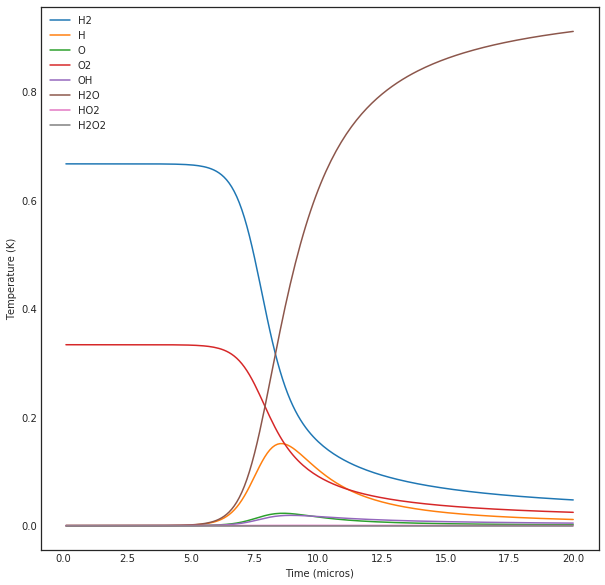

In [396]:
plt.figure(figsize = (10,10))
plt.plot(dict_of_state[1395][:,-1], dict_of_state[1300][:,:8])
plt.xlabel('Time (micros)')
plt.ylabel('Temperature (K)')
plt.legend(states.species_names)
plt.show()

# Create Model

In [225]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '2'
import sys
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

%matplotlib inline

# import cv2
from sklearn.model_selection import train_test_split

from tqdm import tqdm_notebook #, tnrange
#from itertools import chain
from skimage.io import imread, imshow #, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model, save_model
from keras.layers import Input,Dropout,BatchNormalization,Activation,Add, Dense
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K
from keras import optimizers

import tensorflow as tf

from keras.preprocessing.image import array_to_img, img_to_array, load_img#,save_img


In [450]:
# Build model
def build_model(input_layer, hidden_neurons):
    # 101 -> 50
    x = Dense(hidden_neurons, activation = 'sigmoid')(input_layer)
    x = Dense(hidden_neurons, activation = 'sigmoid')(x)
    x = Dense(hidden_neurons, activation = 'sigmoid')(x)
    x = Dense(hidden_neurons, activation = 'sigmoid')(x)
    x = Dense(hidden_neurons, activation = 'sigmoid')(x)
    
    output_layer = Dense(8, activation = 'softmax')(x)
    
    return output_layer

In [454]:
# model
input_layer = Input((10,))
output_layer = build_model(input_layer, 10)

model1 = Model(input_layer, output_layer)

c = optimizers.adam(lr = 0.01)

In [455]:
def loss_function(y_true, y_pred):
    mae = K.abs(y_pred - y_true)
    log =  K.log(K.clip(y_true, K.epsilon(), None)/ K.clip(y_pred, K.epsilon(), None))
    return K.mean(K.abs(log))

In [456]:
model1.compile(loss=loss_function, optimizer=c, metrics=[loss_function])

# Load train

In [457]:
train = pickle.load(open('states.pkl', 'rb'))

In [458]:
matrix = np.vstack([train[keys][:,:10] for keys in train.keys()])

In [459]:
matrix.shape

(8000, 10)

In [460]:
Eps = 1e-16

In [461]:
train_matrix = matrix+Eps

In [462]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()


In [463]:
train_matrix = scaler.fit_transform(train_matrix)

In [464]:
test_matrix = np.roll(matrix, 1, axis=0)

In [465]:
train_matrix

array([[ 1.70206279, -0.87256894, -0.83218709, ..., -2.0755985 ,
        -0.90961097,  0.        ],
       [ 1.70206264, -0.87256836, -0.8321867 , ..., -2.07520325,
        -0.90961097,  0.        ],
       [ 1.70206245, -0.87256765, -0.83218616, ..., -2.07454307,
        -0.90961097,  0.        ],
       ...,
       [-0.7699469 , -0.61666803, -0.59127088, ...,  0.04753315,
         1.25612944,  1.01137881],
       [-0.77069358, -0.61893889, -0.59353714, ...,  0.04731807,
         1.25612944,  1.01137881],
       [-0.77143256, -0.62117488, -0.59576756, ...,  0.04709627,
         1.25612944,  1.01137881]])

In [466]:
test_matrix

array([[4.60336188e-02, 1.32562666e-02, 2.20599568e-03, ...,
        4.17314296e-07, 1.47000000e+03, 1.51987500e+05],
       [6.66666638e-01, 2.65398006e-08, 1.60592761e-09, ...,
        2.58546446e-11, 1.34500000e+03, 1.51987500e+05],
       [6.66666601e-01, 5.68112928e-08, 5.21451743e-09, ...,
        1.03553623e-10, 1.34500000e+03, 1.51987500e+05],
       ...,
       [4.65957049e-02, 1.36155396e-02, 2.26944159e-03, ...,
        4.17441097e-07, 1.47000000e+03, 1.51987500e+05],
       [4.64063889e-02, 1.34939165e-02, 2.24795350e-03, ...,
        4.17400179e-07, 1.47000000e+03, 1.51987500e+05],
       [4.62190372e-02, 1.33741722e-02, 2.22680737e-03, ...,
        4.17357899e-07, 1.47000000e+03, 1.51987500e+05]])

In [ ]:
#early_stopping = EarlyStopping(monitor='my_iou_metric', mode = 'max',patience=10, verbose=1)
model_path = os.path.join("model", '123' + '-epoch-{epoch:03d}' + '-val_loss_function-{val_loss_function:.3f}' + '.hdf5')
model_checkpoint = ModelCheckpoint(model_path,monitor='val_loss_function' , save_best_only=True, verbose=0)
reduce_lr = ReduceLROnPlateau(monitor='val_my_iou_metric', mode = 'max',factor=0.5, patience=10, min_lr=0.0001, verbose=1)


history = model1.fit(x = train_matrix[:-1], y = test_matrix[1:,:8],
                    callbacks=[ model_checkpoint,reduce_lr], 
                    verbose=0,
                    validation_split = 0.1,
                    batch_size = 1024,
                    epochs = 10000)

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:958: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_my_iou_metric` which is not available. Available metrics are: loss,val_loss,lr,loss_function,val_loss_function
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


In [424]:
model1.evaluate(x = train_matrix[:-1], y = test_matrix[1:,:8])

7999/7999 [==============================] - 0s 26us/step


[0.015267941252455248, 0.015267941250650584]

# Evaluate

# true

In [471]:
gas_sub = ct.Solution(thermo='IdealGas', kinetics='GasKinetics',
                       species=species, reactions=reactions)

gas_sub.TPX = 1372, P0, C
r = ct.IdealGasConstPressureReactor(gas_sub, energy ='off')

sim = ct.ReactorNet([r])
time = 0.0
states = ct.SolutionArray(gas_sub, extra=['t'])

for n in range(1000):

    time += 1.e-7
    sim.advance(time)
    states.append(r.thermo.state, t=time*1e6)



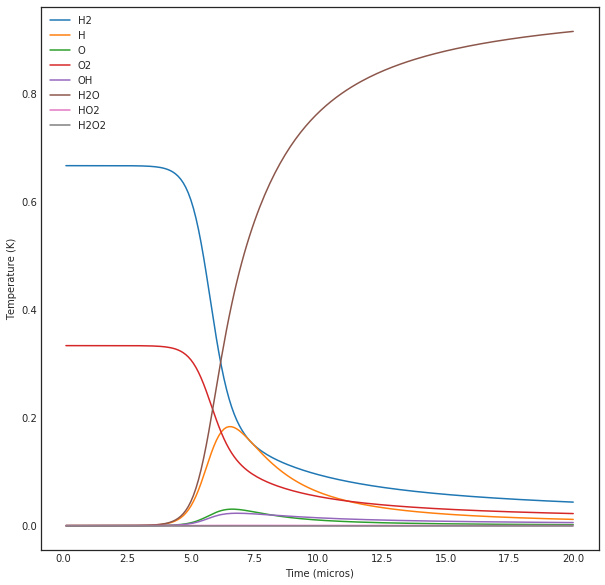

In [472]:
plt.figure(figsize = (10,10))
plt.plot(states.t[:200], states.X[:200])
plt.xlabel('Time (micros)')
plt.ylabel('Temperature (K)')
plt.legend(states.species_names)
plt.show()

# predict

In [473]:
gas_sub = ct.Solution(thermo='IdealGas', kinetics='GasKinetics',
                       species=species, reactions=reactions)

gas_sub.TPX = 1372, P0, C
r = ct.IdealGasConstPressureReactor(gas_sub, energy ='off')

sim = ct.ReactorNet([r])
time = 0.0
states = ct.SolutionArray(gas_sub, extra=['t'])


In [474]:
r.thermo.X

array([0.66666667, 0.        , 0.        , 0.33333333, 0.        ,
       0.        , 0.        , 0.        ])

In [475]:
a = np.vstack([r.thermo.X.reshape(-1,1), np.array(r.thermo.T).reshape(-1,1), np.array(r.thermo.P).reshape(-1,1)]).T

In [476]:
np.array(r.thermo.T).reshape(-1,1).shape

(1, 1)

In [477]:
%%time
all_pred = [a]
for i in range(100):
    norm_input = scaler.transform(a)
    a = model1.predict(norm_input)
    a = np.hstack([a, np.array(r.thermo.T).reshape(-1,1), np.array(r.thermo.P).reshape(-1,1)])
    all_pred.append(a)

CPU times: user 124 ms, sys: 8 ms, total: 132 ms
Wall time: 97.5 ms


In [478]:
all_pred =np.vstack(all_pred)

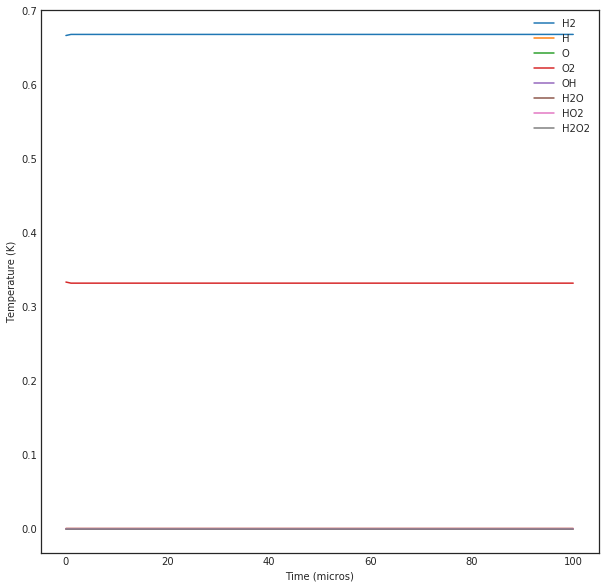

In [479]:
plt.figure(figsize = (10,10))
plt.plot(all_pred[:200,:8])
plt.xlabel('Time (micros)')
plt.ylabel('Temperature (K)')
plt.legend(states.species_names)
plt.show()